In [3]:
if (requireNamespace("thematic")) 
  thematic::thematic_rmd(font = "auto")
suppressPackageStartupMessages({
  library(data.table)
  library(readxl)
  library(showtext)
  library(zoo)
  library(FinTS)
  library(forecast)
  library(ggplot2)
})

library(data.table)
library(readxl)
library(showtext)  
library(forecast)
library(ggplot2)
library(lmtest)
library(urca)
library(FinTS)
library(tseries)
library(knitr)
library(ggplot2)
library(vars)
library(lpirfs)
library(dplyr)
library(tsDyn)
showtext_auto() 


# Introduction

Étant considéré comme l'un des indicateurs économiques les plus importants, le taux de chômage est, depuis maintenant plusieurs décennies, au coeur de nos actualités. Ses fluctuations sont suivies quotidiennement car elles ont des conséquences directes sur notre pays, touchant non seulement l'économie, mais aussi les sphères politique et sociale. Comprendre cet indicateur est donc crucial, en identifiant par exemple les autres indicateurs avec lesquels il peut être corrélé. Dans cette optique, de nombreuses études ont examiné la relation entre chômage et inflation, comme en témoigne la célèbre courbe de Phillips. Pour notre projet, nous avons choisi d'explorer une relation moins étudiée, mais néanmoins pertinente : le lien entre taux de chômage et taux de croissance des crédits accordés aux entreprises non financières, que nous suspectons être causale.

Les variations du taux de chômage exercent une influence directe sur la consommation des ménages, un des moteurs clés de la demande globale, et par extension, sur l’activité économique. De plus, les crédits accordés aux entreprises non financières jouent un rôle essentiel dans le financement de l’investissement, stimulant l’innovation et la croissance. Analyser les interactions entre ces deux indicateurs permet alors de mieux comprendre certains mécanismes macroéconomiques clés.

# Partie 1 : Modélisation univariée

## 1.1 Présentation des séries

Pour étudier cette relation, nous avons collecté une série de données couvrant une période commune pour chaque variable. Nous avons utilisé les données de la section *webStat* du site de la Banque de France, comprenant deux séries sous format CVS, de septembre 2000 à septembre 2019, pour un total de 77 observations.

Le [tx chomage](https://webstat.banque-france.fr/fr/catalogue/sts/STS.Q.FR.S.UNEH.RTT000.4.000), est observé mensuellement et exprimé en pourcentage de la population active. Cette série, couvrant la période de septembre 2000 à septembre 2019, présente une évolution notable, fluctuante entre 6 % et 12 %. Il convient de noter que cette série est déjà corrigée des variations saisonnières, ce qui évite la nécessité d'un ajustement supplémentaire.


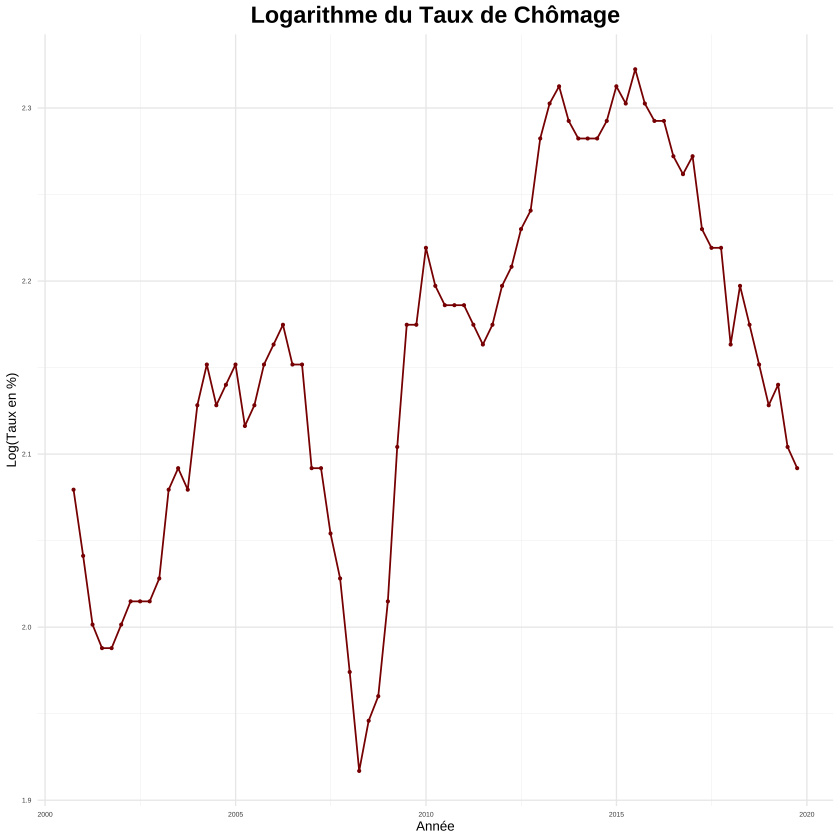

In [11]:
tab_u<-read_excel("/Users/tristan/Desktop/data_chomage.xls")
tab_u$obs_value <- as.numeric(gsub(",", ".", tab_u$obs_value))
tab_u$time_period_start <- as.Date(tab_u$time_period_start)

Taux_de_chomage <- ts(tab_u$obs_value, frequency = 4, start = 
c(as.numeric(format(min(tab_u$time_period_start), "%Y")), 
as.numeric(format(min(tab_u$time_period_start), "%m"))))

#Transformation logarithmique de la série sur le tx de chomage  
tab_u$log_obs_value <- log(tab_u$obs_value)

log_taux_de_chomage <- ts(tab_u$log_obs_value, frequency = 4, start =c(as.numeric(format(min(tab_u$time_period_start), "%Y")),               as.numeric(format(min(tab_u$time_period_start), "%m"))))

# Tracer la série logarithmique du taux de chômage
ggplot(data = tab_u, aes(x = time_period_start, y = log_obs_value)) +
  geom_point(color = 'darkred', size = 0.5) + 
  geom_line(color = "darkred") +  
  labs(title = "Logarithme du Taux de Chômage", x = "Année", y = "Log(Taux en %)") +
  theme_minimal(base_size = 8) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14))


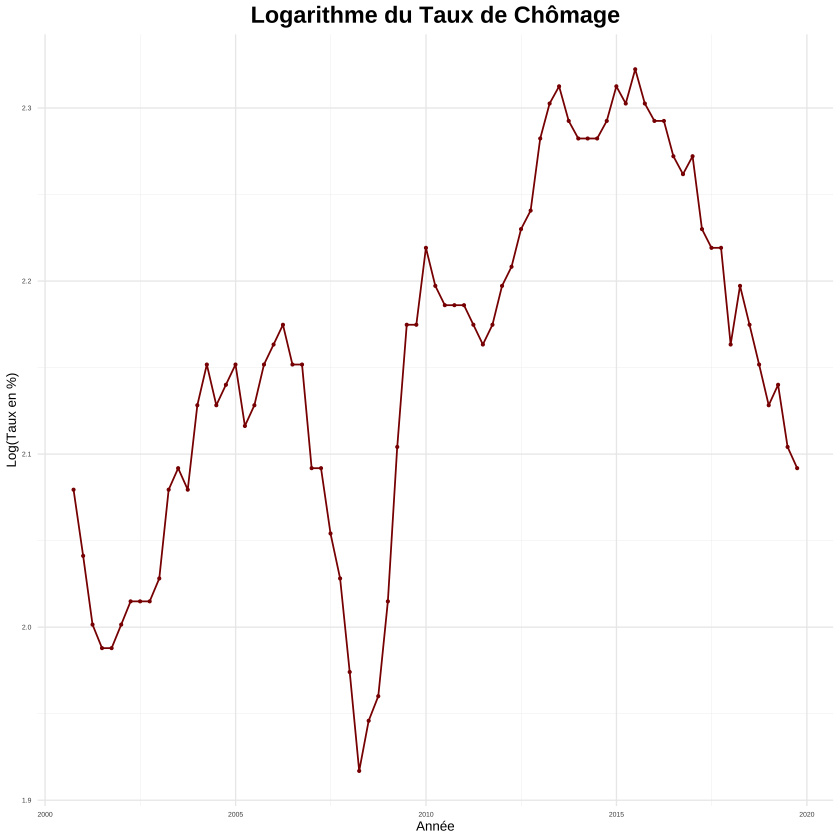

In [14]:
tab_u<-read_excel("/Users/tristan/Desktop/data_chomage.xls")
tab_u$obs_value <- as.numeric(gsub(",", ".", tab_u$obs_value))
tab_u$time_period_start <- as.Date(tab_u$time_period_start)

Taux_de_chomage <- ts(tab_u$obs_value, frequency = 4, start = 
c(as.numeric(format(min(tab_u$time_period_start), "%Y")), 
as.numeric(format(min(tab_u$time_period_start), "%m"))))

#Transformation logarithmique de la série sur le tx de chomage  
tab_u$log_obs_value <- log(tab_u$obs_value)

log_taux_de_chomage <- ts(tab_u$log_obs_value, frequency = 4, start =c(as.numeric(format(min(tab_u$time_period_start), "%Y")),               as.numeric(format(min(tab_u$time_period_start), "%m"))))

# Tracer la série logarithmique du taux de chômage
ggplot(data = tab_u, aes(x = time_period_start, y = log_obs_value)) +
  geom_point(color = 'darkred', size = 0.5) + 
  geom_line(color = "darkred") +  
  labs(title = "Logarithme du Taux de Chômage", x = "Année", y = "Log(Taux en %)") +
  theme_minimal(base_size = 8) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14))

Visuellement la série semble adopter une tendance stochastique et être de type DS, donc non stationnaire. En effet, si l'on ne considère pas la crise de 2008, on observe que l'évolution des valeurs de la série n'a cessé de varier.

Le [taux de croissance des crédits accordés aux entreprises non financières](https://webstat.banque-france.fr/fr/catalogue/bsi1/BSI1.M.FR.Y.R.A2N1Z.A.I.U6.2240.Z01.3), que nous abrègerons TCC, est observé mensuellement et mesuré en taux annualisés. De ce fait, il n'est **pas requis d'effectuer une transformation logarithmique**. Néanmoins, un léger filtre de la série sur *Excel* a été nécessaire en supprimant 3 observations sur 4 afin de la rendre trimestrielle et donc compatible avec la série sur le taux de chômage. Ici encore, la série est corrigée des variations saisonnières.

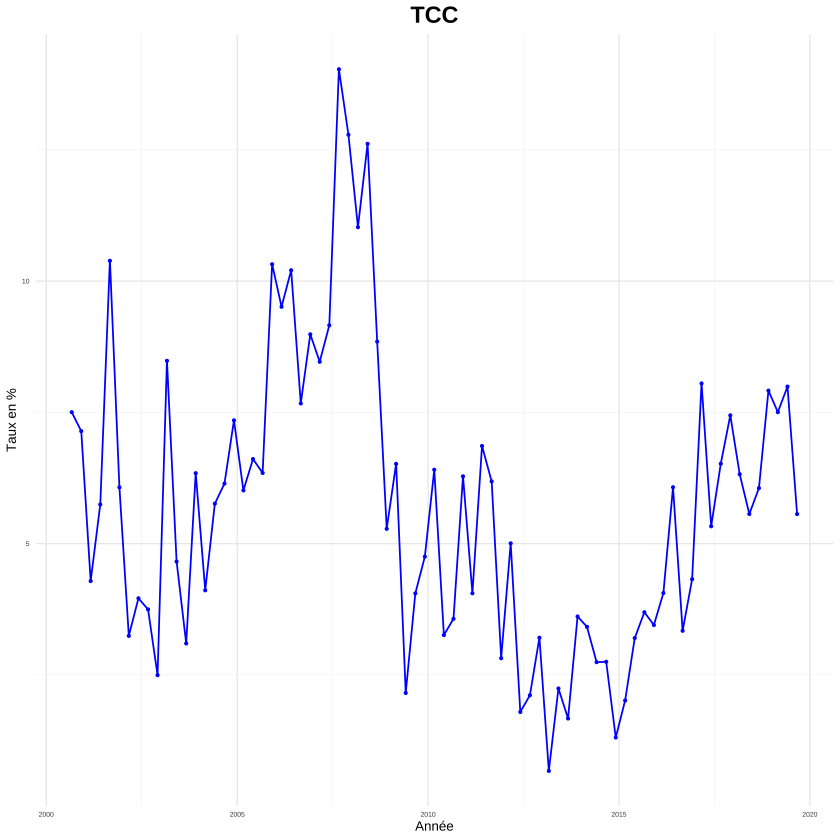

In [17]:
tab <- read_excel("/Users/tristan/Desktop/Data_Bessec.xls")
tab$obs_value <- as.numeric(gsub(",", ".", tab$obs_value))

# Convertir la colonne time_period_start en format Date
tab$time_period_start <- as.Date(tab$time_period_start)


# Création de la série temporelle
TCC <- ts(tab$obs_value, frequency = 4, start = c(as.numeric(format(min(tab$time_period_start), "%Y")), as.numeric(format(min(tab$time_period_start), "%m"))))


par(mfrow=c(1,2))
ggplot(data = tab, aes(x = time_period_start, y = obs_value)) +
  geom_point(color = 'blue', size = 0.5) + 
  geom_line(color = "blue") +  
  labs(title = "TCC", x = "Année", y = "Taux en %") +
  theme_minimal(base_size = 8) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14))

On remarque que le TCC a été positif sur toute la période considérée. Cependant, sa valeur a constamment fluctué avec notamment un pic d'augmentation atteignant 14% entre 2013 et 2015.
On remarque que le taux de chomâge a toujours été positif et a fortement fluctué entre septembre 2000 et septembre 2019. Le taux de chomâge semble admettre une borne inférieure à 6% et une borne supérieure aux alentours de 12%.


## 1.2 Autocorrélogrammes simples et partiels

Une première approche permettant d'appréhender la stationnarité présente ou non dans une série est celle de l'analyse de son autocorrelation. L'autocorrelaton simple d'ordre *h* d'une série est une mesure de sa correlation avec une version décalée de *h* unités temporelles d'elle même. On l'exprime :$\hat{\rho}(h) = \frac{\hat{\Gamma}(h)}{\hat{\Gamma}(0)}$ avec $\hat{\Gamma}(h)$ la fonction d'autocovariance d'ordre *h*. On la différencie de l'autocorrelation **partielle** d'ordre *h* qui ne tient pas compte de l'influence des termes d'ordre inférieurs à *h*. Typiquement, une série non stationnaire verra son autocorrelation simple décroître très lentement avec *h*.

### Le taux de chômage

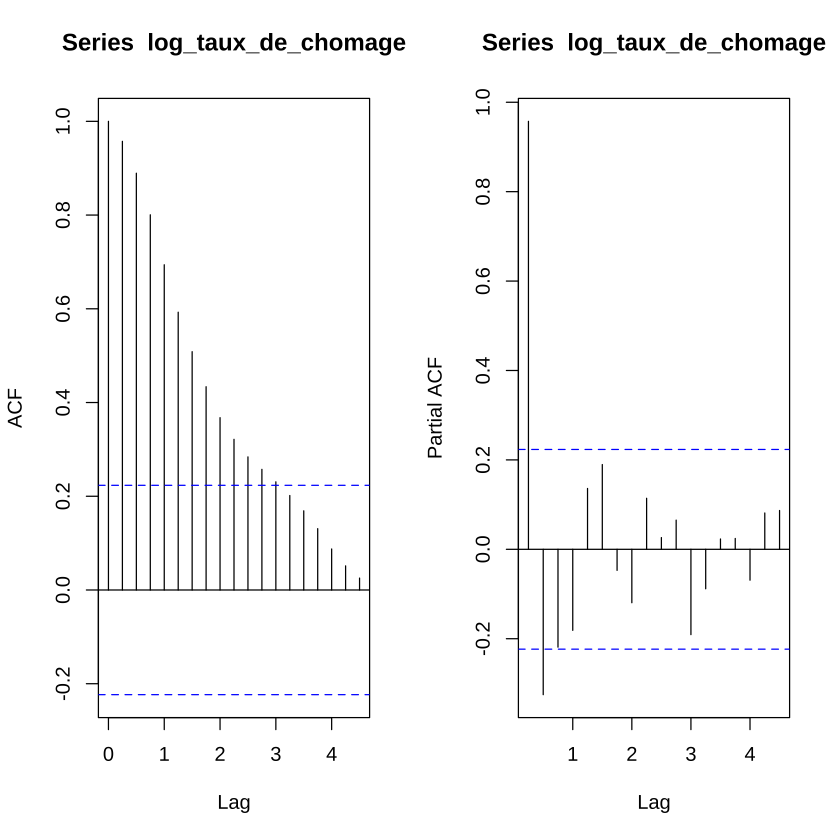

In [20]:
par(mfrow=c(1,2))
acf(log_taux_de_chomage)
pacf(log_taux_de_chomage)

Les autocorrélogrammes du taux de chomâge couplée à l'analyse graphique suggèrent que la série n'est pas stationnaire. En effet, l'ACF décroît lentement avec *h*, et seuls les 2 premiers termes de la PACF sont significatvement différents de 0.

### Le TCC

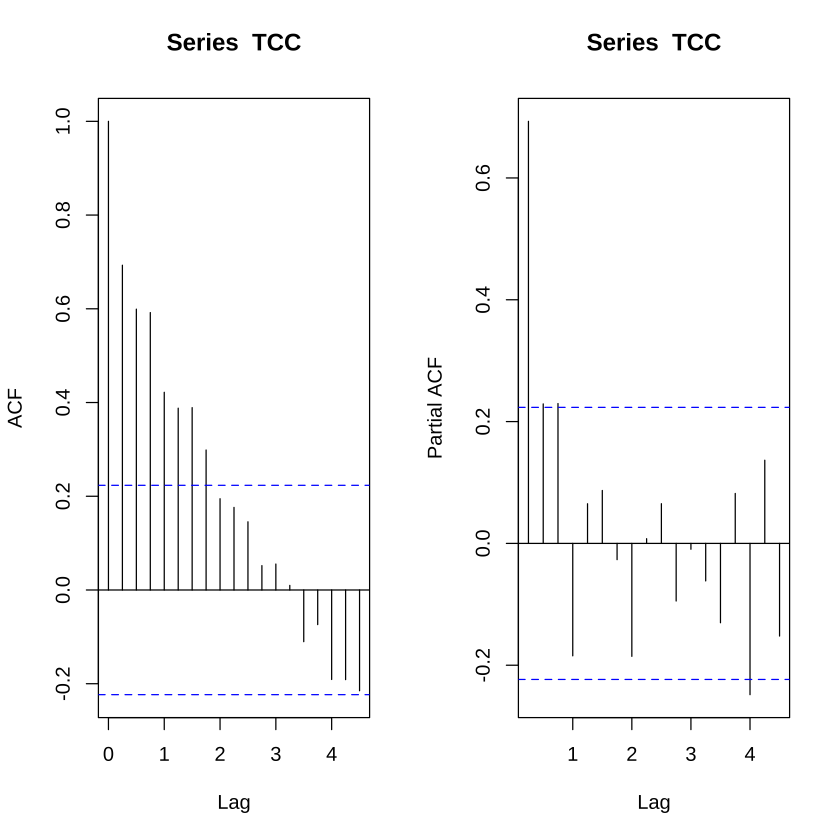

In [23]:
par(mfrow=c(1,2))
acf(TCC)
pacf(TCC)

Là encore, les autocorrélogrammes du TCC suggèrent que la série n'est pas stationnaire. En effet, l'ACF décroît lentement avec *h*, tandis que seuls les 2 premiers termes de la PACF sont significatvement différents de 0.

## 1.3 Test de racine unitaire et stationnarisation

Les racines d'un processus stationnaire doivent être supérieures à 1 en module. Si ce n'est pas le cas, le processus est dit non stationnaire et présente donc une tendance déterministe ou stochastique. Le test de Dickey-Fuller augmenté couplé au test KPSS nous permettent alors de vérifier rigoureusement la stationnarité de nos séries.

Voici les modèles utilisés séquentiellement dans le test de Dickey-Fuller augmenté.

- M3:
$$
\Delta X_t = c + b t + \rho X_{t-1} + \sum_{j=1}^p \delta_j \Delta X_{t-j} + \varepsilon_t
$$
- M2:
$$
\Delta X_t = c + \rho X_{t-1} + \sum_{j=1}^p \delta_j \Delta X_{t-j} + \varepsilon_t
$$
- M1:
$$
\Delta X_t =\rho X_{t-1} + \sum_{j=1}^p \delta_j \Delta X_{t-j} + \varepsilon_t
$$
On teste ensuite sur ces modèles, un test de racine unitaire et un test de significativité des paramètres.

Le test de racine unitaire consiste à tester les hypothèses suivantes:
$$
\left\{
\begin{array}{l}
H_0 : \rho = 0 \\
H_1 : \rho < 0
\end{array}
\right.
$$
On utilise alors la statistique de test:
$$
t = \frac{\hat{\rho}}{\sigma_{\hat{\rho}}}
$$

Le test de significativité des paramètres consiste à tester les hypothèses suivantes (différentes pour chaque modèle).

- M3:
$$
\left\{
\begin{array}{l}
H_0 : b = 0 \\
H_1 : b \neq 0
\end{array}
\right.
$$
On utilise ensuite la statistique de test:
$$
t = \frac{\hat{b}}{\sigma_{\hat{b}}}
$$

- M2:
$$
\left\{
\begin{array}{l}
H_0 : c = 0 \\
H_1 : c \neq 0
\end{array}
\right.
$$
Statistique de test:
$$
t = \frac{\hat{c}}{\sigma_{\hat{c}}}
$$

- M1: le test de racine unitaire est suffisant.

Ensuite, nous réaliserons un test KPSS consistant à tester les hypothèses suivantes:
$$
\left\{
\begin{array}{l}
H_0 : absence\,de\,racine\,unitaire \\
H_1 : presence\,de\,racine\,unitaire
\end{array}
\right.
$$
On utulise alors la statistique de test suivante:
$$
LM = \frac{1}{s^2 T} \sum_{t=1}^{T} PT_t^2
$$

### 1.3.1 Le taux de chômage

**a. Test ADF**

-   **Modele avec constante et terme déterministe M3**

On commence donc par tester le modèle avec constante et terme déterministe.

In [26]:
testM3_u <- ur.df(y=log_taux_de_chomage,type='trend',lags=4,selectlags="AIC")

#Mise sous forme de tableau pour plus de clarté
titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau3 (5%)", "*t stat* du terme déterministe", "Valeur critique (5%) pour *tt*"),
  Valeur = round(c(testM3_u@teststat[1], testM3_u@cval[4], -2.569, 1.96),3)
)

kable(titre,caption="Resultats du test ADF sur M3")



Table: Resultats du test ADF sur M3

|Statistique                    | Valeur|
|:------------------------------|------:|
|Statistique ADF                | -3.596|
|Valeur critique tau3 (5%)      | -3.450|
|*t stat* du terme déterministe | -2.569|
|Valeur critique (5%) pour *tt* |  1.960|

On voit que la statistique ADF est inférieure à la valeur critique *tau3* au seuil de 5%.
On rejete donc $H_0$ au seuil de 5% et on conclut à l'absence d'une RU.
Cependant, on doit donc lire la valeur critique à 5% (pour le test déterministe) dans la table de Student à $77-(4+3)=70>30$, les degrés de liberté étant supérieure à 30, on lit la valeur critique dans la table de la loi normale soit 1,96.
Or on voit que la *t-value* du terme déterministe *tt* est supérieure en valeur absolue à 1.96. On rejette donc $H_0$ au seuil de 5%.
On en conclut que le taux de chomâge suit un processus $(X_t) \sim I(0)+C+T$.


**b. Test KPSS**

In [30]:
kpssM3_u <-ur.kpss(y=log_taux_de_chomage,type="tau",lags="short")

titre <- data.frame(
  Statistique = c("Statistique KPSS","Valeur critique 5%"),
  Valeur = round(c(kpssM3_u@teststat[1],kpssM3_u@cval[2]),3)
)

kable(titre,caption="Resultats du test KPSS")



Table: Resultats du test KPSS

|Statistique        | Valeur|
|:------------------|------:|
|Statistique KPSS   |  0.153|
|Valeur critique 5% |  0.146|

La statistique KPSS étant supérieure à la valeur critique, on rejette $H_0$ au seuil de 5%.

Les résultats des tests statistiques suggèrent que la série est stationnaire autour d'une tendance (TS). Le test ADF, réalisé avec un terme de tendance, rejette l'hypothèse nulle de racine unitaire au seuil de 5% (statistique de test : -3.5957, valeur critique à 5% : -3.45). De plus, le terme de tendance *tt* est significatif (p-value = 0.012), ce qui confirme qu'une composante déterministe influence la série. Par ailleurs, bien que le test KPSS rejette l'hypothèse nulle de stationnarité, cela est cohérent avec sa sensibilité aux tendances résiduelles et à l'autocorrélation. Ces résultats montrent que la série, bien qu'influencée par une tendance déterministe, est stationnaire une fois cette dernière retirée, ce qui caractérise une série TS.

**c Stationnarisation**


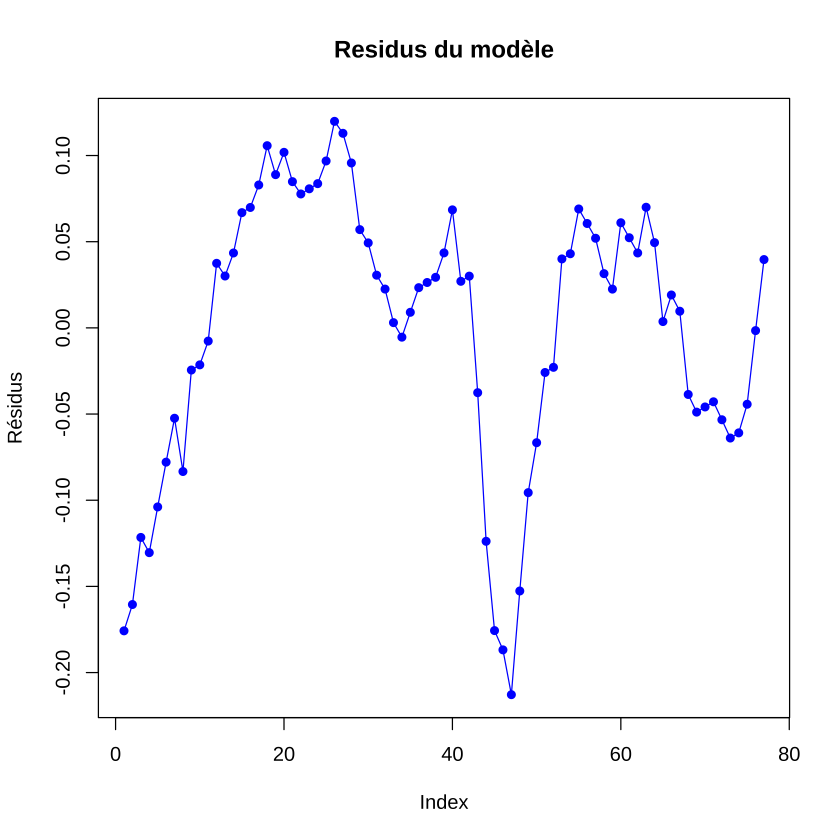

In [33]:
index<-1:77
u<-lm(log_taux_de_chomage~index)
z<-u$residuals
plot(1:77, z, type = "o", col = "blue", pch = 16,
     main = "Residus du modèle",
     xlab = "Index",
     ylab = "Résidus")

Suite au test de Dickey-Fuller augmenté (ADF) réalisé sur la variable M3, nous concluons à l'absence de racine unitaire. Cependant, le coefficient 
b
b s'avère non significatif. Par conséquent, nous procédons au test ADF sur la variable M2. Ce dernier révèle également l'absence de racine unitaire, mais la constante y est jugée non significative.

In [42]:
adf_test_1 <- ur.df(z, type = "none", lags =4,selectlags="AIC")
titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau1 (5%)"),
  Valeur = round(c(adf_test_1@teststat[1], adf_test_1@cval[2]),3)
)
kable(titre,caption="Resultats du test ADF sur M1")



Table: Resultats du test ADF sur M1

|Statistique               | Valeur|
|:-------------------------|------:|
|Statistique ADF           | -3.546|
|Valeur critique tau1 (5%) | -1.950|

Suite au test de Dickey-Fuller simple sur le M1, on conclut à l'absence de racine unitaire.
On a donc bien que la série des résidus est stationnaire car intégrée d'ordre 0.
On vérifie notre résultat avec un test KPSS.


In [44]:
kpssM3_z <-ur.kpss(y=z,type="mu",lags="short")

titre <- data.frame(
  Statistique = c("Statistique KPSS","Valeur critique 5%"),
  Valeur = round(c(kpssM3_z@teststat[1],kpssM3_z@cval[2]),3)
)

kable(titre,caption="Resultats du test KPSS")



Table: Resultats du test KPSS

|Statistique        | Valeur|
|:------------------|------:|
|Statistique KPSS   |  0.153|
|Valeur critique 5% |  0.463|

La statistique KPSS étant inférieure à la valeur critique, on ne rejette pas $H0$. La série *log_taux_de_chomage* est donc de type TS, ce qui signifie qu'elle est stationnaire une fois que la tendance linéaire est retirée. Cela va dans le même sens que le test ADF, où la série ne présente pas de racine unitaire et semble stationnaire.

### 1.3.2 Le TCC

**a. Test ADF**

-   **Modele avec constante et terme déterministe M3**

On commence donc par tester le modèle avec constante et terme déterministe :

In [48]:
testM3 <- ur.df(y=TCC,type='trend',lags=4,selectlags="AIC")

#Mise sous forme de tableau pour plus de clarté
titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau3 (5%)", "*t stat* du terme déterministe", "Valeur critique (5%) pour *tt*"),
  Valeur = round(c(testM3@teststat[1], testM3@cval[4], -2.4836, 3.17),3)
)

kable(titre,caption="Resultats du test ADF sur M3")



Table: Resultats du test ADF sur M3

|Statistique                    | Valeur|
|:------------------------------|------:|
|Statistique ADF                | -2.484|
|Valeur critique tau3 (5%)      | -3.450|
|*t stat* du terme déterministe | -2.484|
|Valeur critique (5%) pour *tt* |  3.170|

La *t value* du terme *z.lag.1* est supérieure à la valeur critique *tau3* ce qui nous conduit donc à ne pas rejeter $H_0$ au seuil de 5% et ainsi conclure à la présence de RU. Cependant, la *t value* du terme déterministe *tt* est inférieure à la valeur critique *3.17* lu dans la table de *Dickey Fuller*. Le coefficient n'est donc pas significatif au seuil de 5% et nous devons alors considérer le modèle 2.

-   **Modele avec constante M2**

In [51]:
testM2 <- ur.df(y=TCC,type='drift',lags=4,selectlags="AIC")

titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau2 (5%)", "*t stat* de *c*", "Valeur critique (5%) pour *c*"),
  Valeur = round(c(testM2@teststat[1], testM2@cval[3], 2.069, 2.88),3)
)

kable(titre,caption="Resultats du test ADF sur M2")



Table: Resultats du test ADF sur M2

|Statistique                   | Valeur|
|:-----------------------------|------:|
|Statistique ADF               | -2.241|
|Valeur critique tau2 (5%)     | -2.890|
|*t stat* de *c*               |  2.069|
|Valeur critique (5%) pour *c* |  2.880|

Ici encore, la *t value* du terme *z.lag.1* est supérieure à la valeur critique *tau2*. Le terme constant n'est pas significatif au seuil de 5% car sa *t value* est inférieure au quantile *2.88* de la table de *Dickey Fuller*. Nous devons alors considérer le modèle 1.

-   **Modele simple M1**

In [54]:
testM1 <- ur.df(y=TCC,type='none',lags=4,selectlags="AIC")

titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau1 (5%)"),
  Valeur = round(c(testM1@teststat[1], testM1@cval[2]),3)
)
kable(titre,caption="Resultats du test ADF sur M1")



Table: Resultats du test ADF sur M1

|Statistique               | Valeur|
|:-------------------------|------:|
|Statistique ADF           | -0.762|
|Valeur critique tau1 (5%) | -1.950|

Finalement, on est encore amené à rejeter $H_0$ car la *t value* du terme *z.lag.1* est supérieure à la valeur critique *tau1* et nous pouvons donc conclure à la présence d'une racine unitaire.

La stratégie de test ADF nous amène donc à considérer un processus intégré d'odre 1 de la forme $(X_t) \sim I(1)$.

**b. Test KPSS**

In [57]:
#si M1 alors on prends M2
kpssM2 <-ur.kpss(y=TCC,type="mu",lags="short")

titre <- data.frame(
  Statistique = c("Statistique KPSS","Valeur critique 5%"),
  Valeur = round(c(kpssM2@teststat[1],kpssM2@cval[2]),3)
)

kable(titre,caption="Resultats du test KPSS")



Table: Resultats du test KPSS

|Statistique        | Valeur|
|:------------------|------:|
|Statistique KPSS   |  0.365|
|Valeur critique 5% |  0.463|


La *t value* étant supérieure à la valeur critique 0.146, nous sommes amené à rejeter l'hypothèse nulle de stationnarité au seuil de 5%, ce qui est cohérent avec les résultats précédents.

**c Stationnarisation**

Les résultats des tests ADF et KPSS montrent que la série suit un processus DS sans dérive. Il suffit donc de la différencier pour la stationnariser. On obtient alors une nouvelle série *dTCC*, dont l'interprétation est moins directe : il s'agit des variations d'un taux de croissance.

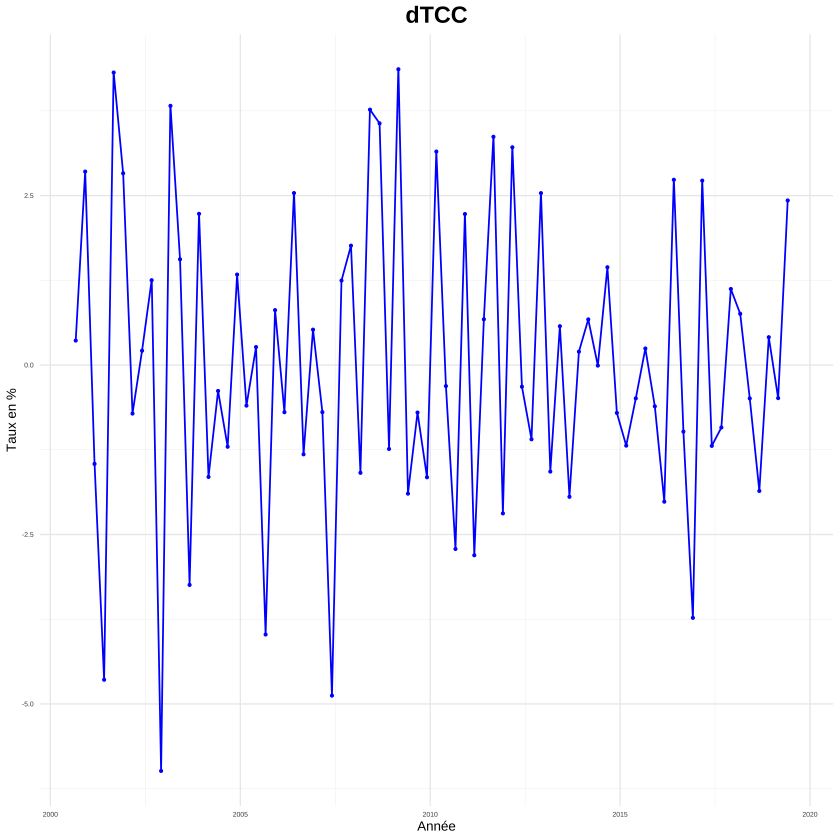

In [74]:
dTCC <- diff(TCC)
dTCC_na <- c(NA, dTCC)
tab$dTCC <- dTCC_na
#plot(dTCC,col='black',main='tx de croissance du TCC',xlab = 'Année')

ggplot(data = tab, aes(x = time_period_start, y = dTCC_na)) +
  geom_point(color = 'blue', size = 0.5, na.rm = TRUE) + 
  geom_line(color = "blue", na.rm = TRUE) +  
  labs(title = "dTCC", x = "Année", y = "Taux en %") +
  theme_minimal(base_size = 8) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14))

Visuellement, cette nouvelle série semble bien stationnaire en étant centrée autour de 0, soit un processus $(X_t) \sim I(0)$. Néanmoins, afin, de garantir la stationnarité de cette série et ainsi pouvoir déterminer le modèle ARMA adapté, il est nécessaire de réaliser à nouveau les tests ADF et KPSS.

In [77]:
testdM1 <- ur.df(y=dTCC,type='none',lags=4,selectlags="AIC")

titre <- data.frame(
  Statistique = c("Statistique ADF", "Valeur critique tau1 (5%)"),
  Valeur = round(c(testdM1@teststat[1], testdM1@cval[2]),3)
)

kable(titre,caption="Resultats du test ADF sur M1 de *dTCC*")



Table: Resultats du test ADF sur M1 de *dTCC*

|Statistique               | Valeur|
|:-------------------------|------:|
|Statistique ADF           | -9.299|
|Valeur critique tau1 (5%) | -1.950|

Après avoir rejeté les modèles M3 et M2 en raison de la non significativté de leur terme de tendance et de leur terme constant (*cf. fichier rmarkdown*), nous testons finalement le modèle M1. Dans celui-ci,la statistique ADF est inférieure à la valeur critique *tau1* ce qui nous amène à rejeter $H_0$, impliquant donc l'abscence de racine unitaire.

In [80]:
#si M1 alors on prends M2
kpssdM2 <-ur.kpss(y=dTCC,type="mu",lags="short")

titre <- data.frame(
  Statistique = c("Statistique KPSS","Valeur critique 5%"),
  Valeur = round(c(kpssdM2@teststat[1],kpssdM2@cval[2]),3)
)

kable(titre,caption="Resultats du test KPSS sur *dTCC*")



Table: Resultats du test KPSS sur *dTCC*

|Statistique        | Valeur|
|:------------------|------:|
|Statistique KPSS   |  0.046|
|Valeur critique 5% |  0.463|

Finalement, la *t value* étant inférieure à la valeur critique 0.146, nous sommes amené à accepter l'hypothèse nulle de stationnarité au seuil de 5%, ce qui est cohérent avec les résultats du test ADF.

On peut donc affirmer, toujours au seuil $\alpha = 0.05$, que la série *dTCC* suit un processus stationnaire.

## 1.3 Détermination du modèle ARMA optimal

### 1.3.1 Recherche des retards *p* et *q*

La stationnarité de la série étant vérifiée, il est donc possible de la modéliser par un processus ARMA(*p*,*q*). Cependant, il faut déterminer le nombre optimal de retards *p* et *q* du modèle. Pour cela, on determine en premier lieu le critère AIC de tous les modèles ARMA allant jusqu'à l'ordre 4 et on choisit celui ayant le critère le plus faible.

In [83]:
mat_aic <- matrix(0,5,5) 
for (i in 0:4){
  for (j in 0:4){
    ARMA_ij <- Arima(y=dTCC,order=c(i,0,j),method="ML")
    mat_aic[i+1, j+1] <- ARMA_ij$aic
  }
}

rownames(mat_aic) <- c('p=0', 'p=1', 'p=2', 'p=3', 'p=4')
colnames(mat_aic) <- c('q=0','q=1','q=2', 'q=3', 'q=4')
print(mat_aic) 

         q=0      q=1      q=2      q=3      q=4
p=0 340.2407 328.0910 329.9701 330.9982 328.0811
p=1 332.4146 330.0124 326.0808 327.7464 327.9390
p=2 327.7931 328.1107 327.6876 329.6744 325.7973
p=3 328.5765 330.0872 329.0969 325.5204 327.4031
p=4 329.0145 330.1655 326.0753 328.2315 326.4186


C'est donc le modèle ARMA(3,3) qui a le critère AIC le plus faible. Il faut désormais s'assurer de la significativité de ses coefficients.

In [91]:
model_a<- Arima(y=dTCC,order=c(3,0,3),include.mean = TRUE)
coeftest(model_a)


z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1        0.254009   0.087378  2.9070  0.003649 ** 
ar2       -0.476402   0.072534 -6.5679 5.102e-11 ***
ar3        0.716842   0.085363  8.3976 < 2.2e-16 ***
ma1       -0.676083   0.074153 -9.1174 < 2.2e-16 ***
ma2        0.676074   0.208518  3.2423  0.001186 ** 
ma3       -0.999991   0.243935 -4.0994 4.142e-05 ***
intercept  0.032829   0.036081  0.9099  0.362884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Le terme constant n'étant pas significatif, on considére un modèle sans celui-ci.

In [93]:
model_b<- Arima(y=dTCC,order=c(3,0,3),include.mean = FALSE)
coeftest(model_b)


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1  0.268213   0.088822  3.0197   0.00253 ** 
ar2 -0.469773   0.083800 -5.6059 2.072e-08 ***
ar3  0.732692   0.086253  8.4947 < 2.2e-16 ***
ma1 -0.675363   0.411002 -1.6432   0.10034    
ma2  0.673406   1.705967  0.3947   0.69304    
ma3 -0.998030   2.104082 -0.4743   0.63526    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Une fois le terme constant retiré du modèle, aucun des coefficients *MA* n'est siginificatif. Pour pallier cela, 2 stratégies sont possibles :

-   La première consiste simplement à retirer tous les termes *MA* soit à considérer un modèle ARMA(3,0). Cependant, en continuant cette stratégie, l'on résulte finalement avec un modèle ARMA(1,0) ayant un critère AIC de 332.41.

-   La seconde consiste à retirer uniquement un seul terme *MA* afin d'analyser ensuite comment évolue la significativité des autres termes. En effectuant cela, on est amené à tester un modèle ARMA(3,2) et on constate qu'un seul coeficient *AR* n'est pas significatif. On considère donc finalement un modèle ARMA(2,2) dont tous les coefficients sont significatifs et ayant un critère AIC de 327.69.

In [96]:
model_c<- Arima(y=dTCC,order=c(3,0,2),include.mean = FALSE)
coeftest(model_c)


z test of coefficients:

     Estimate Std. Error  z value  Pr(>|z|)    
ar1 -0.690797   0.131320  -5.2604 1.437e-07 ***
ar2 -1.010152   0.100050 -10.0965 < 2.2e-16 ***
ar3 -0.153451   0.133205  -1.1520    0.2493    
ma1  0.343264   0.058255   5.8924 3.806e-09 ***
ma2  0.999993   0.132252   7.5613 3.992e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [98]:
model_d<- Arima(y=dTCC,order=c(2,0,2),include.mean = FALSE)
coeftest(model_d)


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1 -0.539602   0.088691 -6.0841 1.172e-09 ***
ar2 -0.869260   0.103760 -8.3776 < 2.2e-16 ***
ma1  0.259445   0.108051  2.4011   0.01634 *  
ma2  0.900085   0.122465  7.3497 1.986e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


On choisira donc le modèle ARMA(2,2) du fait de son critère AIC plus faible que celui de l'ARMA(1,0). Une fois le modèle estimé, on peut l'écrire : \[
X_t = -0.5396 X_{t-1} - 0.8693 X_{t-2} + \epsilon_t + 0.2594 \epsilon_{t-1} + 0.9001 \epsilon_{t-2}
\]

On vérifie ensuite que les racines du polynôme $\phi(L)$ satisfont bien les conditions de stationnarité en étant contenue dans le cercle unitaire.

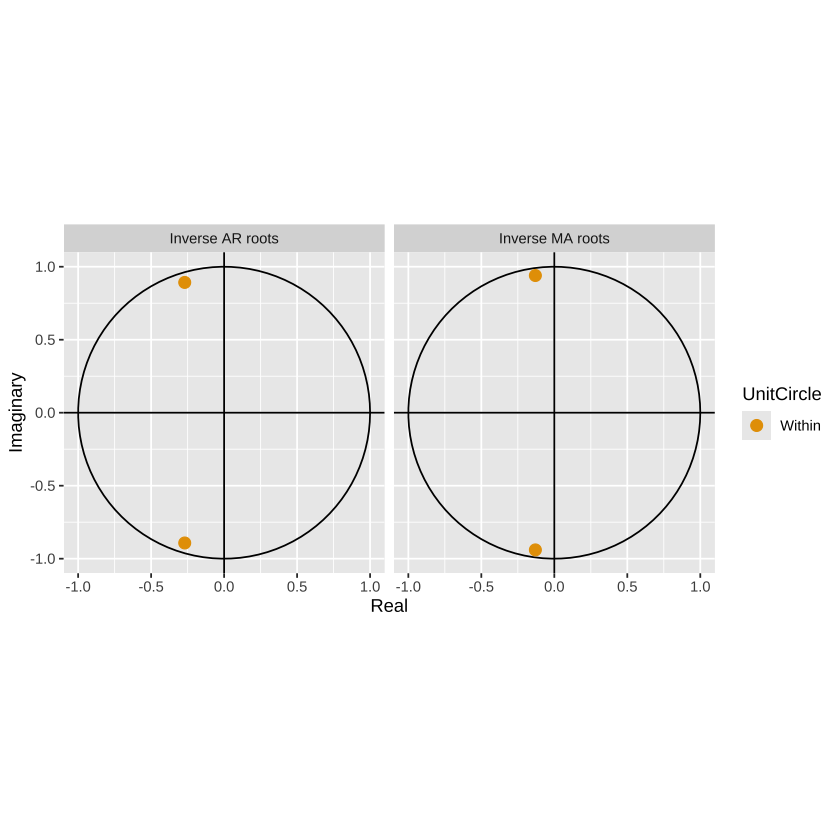

In [102]:
autoplot(model_d)

L'analyse des racines inverses du modèle montre qu'elles sont bien à l'intérieur du cercle unité, ce qui confirme que le modèle satisfait les conditions de stationnarité et d'inversibilité. Cependant, leur proximité avec le cercle unité suggère une persistance des chocs, qui peut entraîner une autocorrélation prolongée dans les données. Bien que cette caractéristique ne remette pas en cause la stationnarité, elle pourrait affecter la précision des prévisions à long terme.

### 1.3.2 Analyse des résidus

Il est nécessaire de vérifier la qualité d'ajustement du modèle ARMA(2,2) en s'assurant que ses résidus se comportent comme un bruit blanc : non autocorrélés, de variance constante et suivant une loi normale.

#### a. Autocorrélation
\
Pour vérifier l'absence d'autocorrélation dans les résidus du modèle ARMA(2,2), nous avons choisi d'utiliser le test de Ljung-Box. La statistique de test $Q^*$ est calculée ainsi :

$$
Q^* = n(n+2) \sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n - k}
$$

où $n$ est la taille de l'échantillon, $h$ est le nombre de décalages, et $\hat{\rho}_k$ l'autocorrélation des résidus au décalage $k$. Sous l'hypothèse nulle $H_0$, $Q^*$ suit une loi du chi-deux avec $h - \text{df}$ degrés de liberté.

Pour notre modèle ARMA(2,2), $Q^* = 4.908$, avec $\text{df} = 4$ et une $p$-value de $0.2969$. Cette $p$-value étant supérieure à $0.05$, nous ne rejetons pas $H_0$, ce qui indique que **les résidus sont bien non autocorrélés** et que le modèle est adapté.


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with zero mean
Q* = 4.908, df = 4, p-value = 0.2969

Model df: 4.   Total lags used: 8



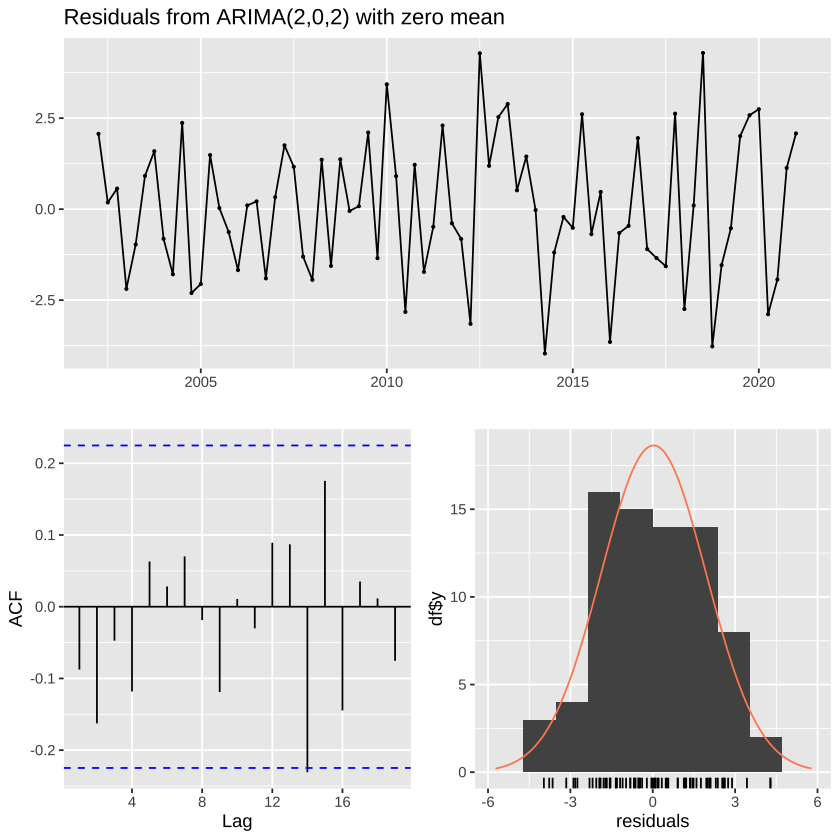

In [105]:
#Test de Ljung-Box
checkresiduals(model_d,lags=20)

#### b. Homoscédasticité
\
Le test d'absence d'effet ARCH de *Engle* est utilisé pour détecter la présence d'hétéroscédasticité dans les résidus du modèle. La statistique de test utilisée est celle du multiplicateur de Lagrange et est calculée ainsi :

$$
LM = T' \cdot R^2
$$

où $T'= T-p$ avec $T$ le nombre d'observations et $p$ le nombre de retard retenus pour le test. $R^2$ est le coefficient de détermination de la régression des carrés des résidus sur leurs propres retards. Sous l'hypothèse nulle $H_0$, cette statistique suit une loi du chi-deux avec $\text{df}$ degrés de liberté, correspondant au nombre de retards testés.

Pour notre modèle, $LM = 16.099$ avec $\text{df} = 20$ et une $p$-value de $0.7105$. Comme cette $p$-value est bien supérieure à $0.05$, nous ne rejetons pas $H_0$. Cela indique **l'absence d'effets ARCH significatifs dans les résidus**, ce qui confirme la stabilité de la variance du modèle.

In [108]:
ArchTest(model_d$residuals,lags=20)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  model_d$residuals
Chi-squared = 16.099, df = 20, p-value = 0.7105


#### c. Distribution normale
\
Dans le cadre de l'évaluation de la normalité des résidus, le test de Jarque-Bera est couramment utilisé pour détecter toute déviation significative de l’asymétrie (skewness) et de l’aplatissement (kurtosis) par rapport à ceux d’une distribution normale. Sous l'hypothèse nulle ($H_0$) de normalité, la statistique de test suit une distribution du chi-deux avec deux degrés de liberté.

$$
JB = \frac{T}{6} \left( \hat{S}^2 + \frac{(\hat{K} - 3)^2}{4} \right)
$$

où la statistique suit une loi du $\chi^2$ à deux degrés de liberté sous l'hypothèse nulle de normalité des résidus.

Les termes sont définis comme suit :

- $T$ : nombre d’observations
- $k$ : nombre de paramètres estimés (0 pour une série brute)
- $\hat{S} = \frac{\hat{\mu}_3}{\hat{\mu}_2^{3/2}}$ : coefficient d’asymétrie (skewness)
- $\hat{K} = \frac{\hat{\mu}_4}{\hat{\mu}_2}$ : coefficient d’aplatissement (kurtosis)
- $\hat{\mu}_k = \frac{\sum_{t=1}^T (y_t - \bar{y})^k}{T}$ : moment empirique centré d’ordre $k$

Dans notre cas, $X^2 = 1.2533$, avec une $p$-value de $0.5344$. Cette $p$-value étant supérieure à $0.05$, nous ne rejetons pas $H_0$, ce qui suggère que **les résidus suivent bien une distribution normale**.


In [111]:
jarque.bera.test(model_d$residuals)


	Jarque Bera Test

data:  model_d$residuals
X-squared = 1.2533, df = 2, p-value = 0.5344


## 1.4 Prévision

Nous savons désormais que le comportement des résidus du modèle est satisfaisant, il est donc possible d'établir des prévisions. Cependant, comme mentionné précèdemment, ces prévisions seront limitées à un horizon assez court du à la proximité des racines du modèle avec le cercle unitaire

### 1.4.1 Hypothèses nécessaires

#### a. Espérance 
\
Pour un horizon de prévision $h$, la prévision optimale de la valeur future $Y_{T+h}$, notée $\hat{Y}_T(h)$, est donnée par l'espérance conditionnelle de $Y_{T+h}$ sachant l'ensemble des informations disponibles à l'instant $T$, noté $I_T$ :

$$
\hat{Y}_T(h) = E(Y_{T+h} \mid {I}_T)
$$
avec $I_T=(Y_1,\dots,Y_T)$

Les prévisions s'appuient sur les propriétés suivantes :

1. La prévision optimale de $Y_{T+i}$ à partir de l’information disponible en $T$, notée $\hat{Y}_T(i)$, est donnée par :
   $$
   E(Y_{T+i} \mid I_T) = \hat{Y}_T(i) \quad \text{pour } i > 0
   $$

2. Les innovations $\epsilon_t$ sont indépendantes et centrées, ce qui implique :
   $$
   E(\epsilon_{T+i} \mid I_T) = 0 \quad \text{pour } i > 0
   $$

Dans le contexte de la prévision en $T$ :
- Les valeurs passées $Y_{T-i}$ (pour $i \geq 0$) sont connues.
- Les valeurs futures $Y_{T+i}$ (pour $i > 0$) sont inconnues et donc remplacées par leur prévision $\hat{Y}_T(i)$.
- De même, les innovations passées $\epsilon_{T-i}$ sont connues, tandis que les innovations futures $\epsilon_{T+i}$ sont supposées de moyenne nulle.

#### b. Intervalle de précision
\
On définit l'erreur de prévision de $Y_{T+h}$ faite en $T$ :
$$
\hat{e}_T(h)=Y_{T+h}-\hat{Y}_T(h)
$$

Sous l'hypothèse de normalité des chocs, vérifiée par le test de *Jarque Bera*, l'erreur de prévision \( \hat{\epsilon}_T(h) \) suit une loi normale \(\mathcal{N}(0, V)\), avec \( V = V(\hat{\epsilon}_T(h)) \).

La statistique normalisée associée est définie par :
$$
\frac{Y_{T+h} - \hat{Y}_T(h)}{\sqrt{\hat{V}}} \sim \text{St}(T - K)
$$
où $\text{St}(T - K)$ représente la loi de Student si $T - K < 30$, et une loi normale $\mathcal{N}(0,1)$ pour $T - K \geq 30$.

L'intervalle de prévision au niveau de confiance \(1 - \alpha\) est alors donné par :
$$
\text{IP} = \left[\hat{Y}_T(h) - t_{1 - \frac{\alpha}{2}} \sqrt{\hat{V}}, \; \hat{Y}_T(h) + t_{1 - \frac{\alpha}{2}} \sqrt{\hat{V}}\right]
$$
où $t_{1 - \frac{\alpha}{2}}$ est le quantile d'ordre $1 - \frac{\alpha}{2}$ de la loi de Student ou de la loi normale.

### 1.4.2 Calcul

In [114]:
# Coefficients du modèle
coefficients <- coef(model_d)
phi1 <- coefficients["ar1"] # Coefficient AR(1)
phi2 <- coefficients["ar2"] # Coefficient AR(2)
theta1 <- coefficients["ma1"] # Coefficient MA(1)
theta2 <- coefficients["ma2"] # Coefficient MA(2)

# Dernières valeurs des séries et des résidus
Y_T <- tail(model_d$x, 1)
Y_T_1 <- tail(model_d$x, 2)[1]
eps_T <- tail(residuals(model_d), 1)
eps_T_1 <- tail(residuals(model_d), 2)[1]

- Pour $h=1$ :

In [116]:
Y_t1 <- phi1 * Y_T + phi2 * Y_T_1 + theta1 * eps_T + theta2 * eps_T_1
print(Y_t1)

          Qtr1
2021 -1.117214


- Pour $h=2$ : 

In [119]:
eps_T1 <- 0  # Résidu futur supposé nul
Y_t2 <- phi1 * Y_t1 + phi2 * Y_T + theta1 * eps_T1 + theta2 * eps_T
print(Y_t2)

         Qtr1
2021 2.161302


- Pour $h=3$ :

In [122]:
eps_T2 <- 0  # Résidu futur supposé nul
Y_t3 <- phi1 * Y_t2 + phi2 * Y_t1 + theta1 * eps_T2 + theta2 * eps_T1
print(Y_t3)

           Qtr1
2021 -0.1950931


À partir du package *forecast* de *R*, on vérifie ensuite facilement la validité de ces prévisions et leur intervalle : 



|        | Point Forecast|  Lo 95| Hi 95|
|:-------|--------------:|------:|-----:|
|2021 Q2 |         -1.117| -4.956| 2.722|
|2021 Q3 |          2.161| -1.825| 6.148|
|2021 Q4 |         -0.195| -4.242| 3.852|
|2022 Q1 |         -1.773| -5.859| 2.312|

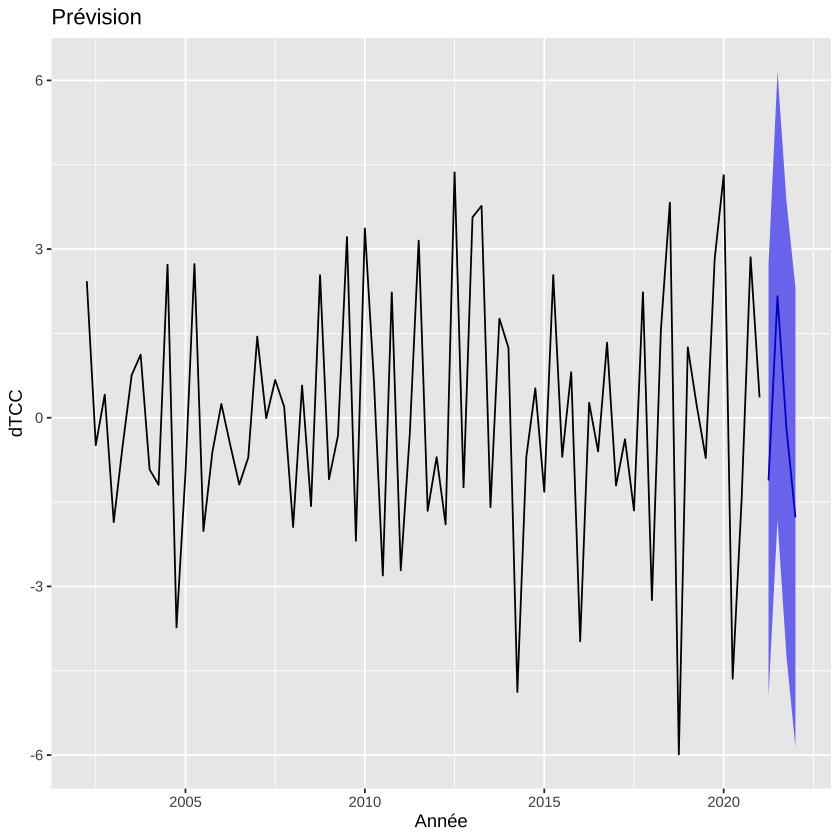

In [125]:
forecast_model_d<-forecast(model_d,h=4,level=95)

# Limite à 3 décimales
forecast_model_d$mean <- round(forecast_model_d$mean, 3)
forecast_model_d$lower <- round(forecast_model_d$lower, 3)
forecast_model_d$upper <- round(forecast_model_d$upper, 3)

kable(forecast_model_d)
autoplot(forecast_model_d,main='Prévision',xlab='Année',ylab='dTCC')

On peut désormais établir les prévisons de la série non filtrée *TCC*. En effet, nous avions établi que la série suivait un processus de type $DS$ de la forme : 
$$
(1 - L) X_t = Y_t 
$$

$$
\iff X_t = Y_t + X_{t-1}
$$
On peut donc déduire les prévisions de $X_t$ à des horizons de 1,
2 et 3 de manière itérative avec $X_t=5.563$.

- Pour $h=1$ :

\begin{equation}
\begin{aligned}
\hat{X}_T (1) &= E(Y_{T+1} + X_T \mid \mathcal{I}_T) = \hat{Y}_T (1) + X_T \\
\iff \hat{X}_T (1) &= -1.117 + 5.563 \\
\iff \hat{X}_T (1) &= 4.446
\end{aligned}
\end{equation}

- Pour $h=2$ :

$$
\hat{X}_T (2)= 2.161 + 5.563=7.724
$$

- Pour $h=3$ :
$$
\hat{X}_T (3)= -0.195 + 5.563=5.368
$$


# Partie 2 : Modélisation multivariée

Dans cette section, nous élargissons notre analyse en adoptant une approche multivariée afin d'explorer les relations dynamiques entre le taux de chômage et le taux de croissance des crédits accordés aux entreprises non financières. Cette perspective permet de modéliser les interactions entre ces deux variables économiques clés et d'évaluer dans quelle mesure leurs évolutions conjointes peuvent améliorer la qualité des prévisions. Nous nous appuierons sur des modèles VAR (Vector AutoRegressive) pour capturer la structure temporelle et les interdépendances entre ces séries, tout en examinant les mécanismes de transmission potentiels au sein du système économique.

## 2.1 Estimation du modèle VAR

Pour procéder à l'estimation du modèle, il est nécessaire de déterminer le nombre de retards optimal de celui-ci. Pour cela, on va estimer différents modèles VAR(*p*) (avec *p* compris entre 0 et 6) et choisir celui qui minimise le critère *AIC*.

In [128]:
#Necessaire rendre compatible la taille des séries 
z<-z[-1]

In [133]:
endogen <- ts.intersect(dTCC,z)
pselec <- VARselect(y=endogen,lag.max=4,type='none')
pselec$criteria
pselec$selection

,1,2,3,4
AIC(n),-5.64068691,-5.872026725,-5.990778144,-6.035575393
HQ(n),-5.59033427,-5.771321444,-5.839720223,-5.834164832
SC(n),-5.51420546,-5.619063823,-5.611333791,-5.529649589
FPE(n),0.00355053,0.002817803,0.002503656,0.002396532


AIC(n)  HQ(n)  SC(n) FPE(n) 
     4      3      2      4

In [135]:
pniv<-4
aic_values <- round(pselec$criteria[1, ],2) 

aic_table <- data.frame(
  Criteria = "AIC",  # Ajouter un titre pour la ligne
  t(aic_values)      # Transposer les valeurs
)

# Ajuster les noms des colonnes pour afficher les lags
colnames(aic_table) <- c("Criteria", paste0("Lag ", seq_along(aic_values)))

kable(aic_table, caption = "Critères AIC par lag")



Table: Critères AIC par lag

|Criteria | Lag 1| Lag 2| Lag 3| Lag 4|
|:--------|-----:|-----:|-----:|-----:|
|AIC      | -5.64| -5.87| -5.99| -6.04|

Le critère d'information *AIC* étant minimal pour $p=4$, nous pouvons maintenant procéder à l'estimation d'un VAR(4). Cependant, il est nécessaire de faire un compromis concernant la tendance déterministe du VAR : la série *dTCC* a été différenciée mais la série *log_taux_de_chomage* est de type TS. Nous avons donc choisi de n'inclure aucune composante déterministe ou constante dans le VAR car la série *dTCC* est déjà stationnaire après différenciation, et la tendance de la série *log_taux_de_chomage* a été correctement capturée dans sa transformation. Par conséquent, un modèle VAR sans constante ni tendance est approprié pour nos données.

In [138]:
#estimation du VAR(5)
var5 <-VAR(y=endogen, lag.max=pniv,type='none')

# Extraire les résultats de la summary du VAR(5)
var5_summary <- summary(var5)

# Récupérer les coefficients, erreurs standards, t-statistics et p-values pour chaque équation
coef_list <- lapply(var5_summary$varresult, function(equation) {
  data.frame(
    Variable = rownames(equation$coefficients),
    Estimate = round(equation$coefficients[, 1], 2),
    StdError = round(equation$coefficients[, 2], 2),
    TValue = round(equation$coefficients[, 3], 2),
    PValue = round(equation$coefficients[, 4], 4)
  )
})

# Ajout d'une colonne pour indiquer l'équation
for (i in seq_along(coef_list)) {
  coef_list[[i]]$Equation <- names(var5_summary$varresult)[i]
}

# Combiner les résultats pour toutes les équations dans un seul data frame
var5_table <- do.call(rbind, coef_list)

# Réorganiser les colonnes pour un tableau lisible
var5_table <- var5_table %>%
  select(Equation, Variable, Estimate, StdError, TValue, PValue)

# Générer le tableau avec kable
kable(
  var5_table,
  caption = "Résultats de l'estimation du VAR(5)",
  align = "lcccc"
)



Table: Résultats de l'estimation du VAR(5)

|             |Equation | Variable | Estimate | StdError | TValue |PValue |
|:------------|:--------|:--------:|:--------:|:--------:|:------:|:------|
|dTCC.dTCC.l1 |dTCC     | dTCC.l1  |  -0.59   |   0.12   | -4.85  |0.0000 |
|dTCC.z.l1    |dTCC     |   z.l1   |  -6.93   |   8.68   | -0.80  |0.4276 |
|dTCC.dTCC.l2 |dTCC     | dTCC.l2  |  -0.54   |   0.13   | -4.08  |0.0001 |
|dTCC.z.l2    |dTCC     |   z.l2   |  -30.84  |  12.81   | -2.41  |0.0190 |
|dTCC.dTCC.l3 |dTCC     | dTCC.l3  |  -0.19   |   0.13   | -1.41  |0.1633 |
|dTCC.z.l3    |dTCC     |   z.l3   |  22.53   |  12.82   |  1.76  |0.0837 |
|dTCC.dTCC.l4 |dTCC     | dTCC.l4  |  -0.28   |   0.12   | -2.39  |0.0200 |
|dTCC.z.l4    |dTCC     |   z.l4   |   9.30   |   9.00   |  1.03  |0.3057 |
|z.dTCC.l1    |z        | dTCC.l1  |   0.00   |   0.00   | -0.41  |0.6796 |
|z.z.l1       |z        |   z.l1   |   1.09   |   0.12   |  8.84  |0.0000 |
|z.dTCC.l2    |z        | dTCC.l2  |   0.0

Après estimation du VAR(4), on remarque que la plupart des coefficients ne sont pas significatifs. Ceci peut être causé par deux raisons :

- une forte **multicolinéarité** : cela peut se produire lorsque les variables explicatives dans le modèle sont fortement corrélées entre elles, ce qui rend difficile l'estimation précise des coefficients. La multicolinéarité peut entraîner des intervalles de confiance larges pour les coefficients et rendre les tests de significativité moins fiables.

- un **manque de corrélation** : si les deux séries ne sont pas suffisamment corrélées, le modèle VAR peut ne pas capter une relation significative entre elles. Dans ce cas, les coefficients associés aux variables non corrélées peuvent être statistiquement non significatifs. 

Pour autant, les racines du modèle en module sont bien inférieures à 1, garantissant sa stationnarité.

In [141]:
# Extraire les racines du modèle VAR(5)
racines_5 <- roots(var5, modulus = TRUE)

# Convertir les résultats en un data frame avec les racines sur une seule ligne
racines_df <- data.frame(t(round(racines_5, 2)))

# Générer le tableau avec kable
kable(
  racines_df,
  caption = "Racines du modèle VAR(5)",
  align = "c"
)



Table: Racines du modèle VAR(5)

|  X1  |  X2  |  X3  |  X4  |  X5  |  X6  | X7  | X8  |
|:----:|:----:|:----:|:----:|:----:|:----:|:---:|:---:|
| 0.87 | 0.87 | 0.78 | 0.78 | 0.58 | 0.58 | 0.5 | 0.5 |

De plus, on vérifie bien que les résidus du modèle ne sont pas autocorrélés : 

In [144]:
test_results <- serial.test(var5, lags.pt = 10, type = "PT.adjusted")

test_results <- data.frame(
  Statistique = c("Chi-squared", "Degrés de liberté (df)", "p-value"),
  Valeur = round(c(18.873, 20, 0.5301),2)
)

kable(test_results, caption = "Portmanteau Test (adjusted)")



Table: Portmanteau Test (adjusted)

|Statistique            | Valeur|
|:----------------------|------:|
|Chi-squared            |  18.87|
|Degrés de liberté (df) |  20.00|
|p-value                |   0.53|

La $pvalue$ étant supérieure à 5%, on ne rejette pas $H0$ et pouvons conclure que les résidus ne sont pas autocorrélés.

## 2.2 Test de causalité

Avant de procéder à l'analyse de la causalité, il est essentiel d'examiner si l'une des variables permet de prédire les variations de l'autre. Pour ce faire, nous utilisons le test de causalité au sens de Granger, qui évalue si les informations passées d'une série améliorent la prévision d'une autre.

In [147]:
TC1<-causality(var5,cause="dTCC") # DC -> DY ?
TC1$Granger
TC2<-causality(var5,cause="z") # DY -> DC ?
TC2$Granger


	Granger causality H0: dTCC do not Granger-cause z

data:  VAR object var5
F-Test = 0.80405, df1 = 4, df2 = 128, p-value = 0.5247



	Granger causality H0: z do not Granger-cause dTCC

data:  VAR object var5
F-Test = 6.2395, df1 = 4, df2 = 128, p-value = 0.000128



Les résultats du test sont particulièrement intéressants. Ils **contredisent** notre intuition initiale selon laquelle le taux de croissance des crédits accordés aux entreprises influencerait le taux de chômage. En effet, la *p-value* de l'hypothèse selon laquelle il n'y a pas de causalité entre la différentielle du taux de croissance des crédits (*dTCC*) et le taux de chômage (*z*) est de 0.7, ce qui indique que nous ne rejetons pas l'hypothèse nulle. Autrement dit, il n'y a pas de preuve significative de causalité de *dTCC* vers *z*. 

En revanche, la *p-value* de l'hypothèse selon laquelle le taux de chômage (*z*) ne cause pas la différentielle du taux de croissance des crédits (*dTCC*) est très faible ($3.06e-05$), ce qui nous pousse à rejeter l'hypothèse nulle. Cela suggère que le taux de chômage a une influence significative sur la différentielle du taux de croissance des crédits accordés aux entreprises.

Ces résultats peuvent refléter l’impact des conditions du marché du travail sur les anticipations économiques des entreprises. Un chômage élevé pourrait inciter à une prudence accrue dans l'octroi ou la demande de crédits, notamment en raison d'une consommation atone et d'une confiance affaiblie dans la capacité de remboursement. À l'inverse, un marché du travail en bonne santé favorise les perspectives de croissance, stimulant ainsi la dynamique de crédit.

## 2.3 Analyse impulsion-repulsion

Nous prolongeons maintenant l’analyse des relations dynamiques entre les variables en recourant à l’approche impulsion-répulsion. Cette méthodologie permettant d’examiner la réponse des variables du système à un choc exogène affectant une variable spécifique. Pour cela, nous passerons par deux méthodes : celle des VAR (a) et cette des projections locales (b).

### a. Méthode des VAR

Dans le cadre de l’analyse VAR, nous utilisons une décomposition de Choleski pour identifier les chocs exogènes, en plaçant les variables selon leur causalité. Le test de Granger a montré que *z* (résidus du log taux de chômage) cause *dTCC* (différentiel de croissance des crédits), justifiant ainsi de placer *z* en première position. La décomposition de Cholesky suppose que les chocs sont orthogonaux, ce qui permet d’isoler les effets spécifiques de chaque variable. Cet ordre est crucial, car une mauvaise spécification peut biaiser les résultats.

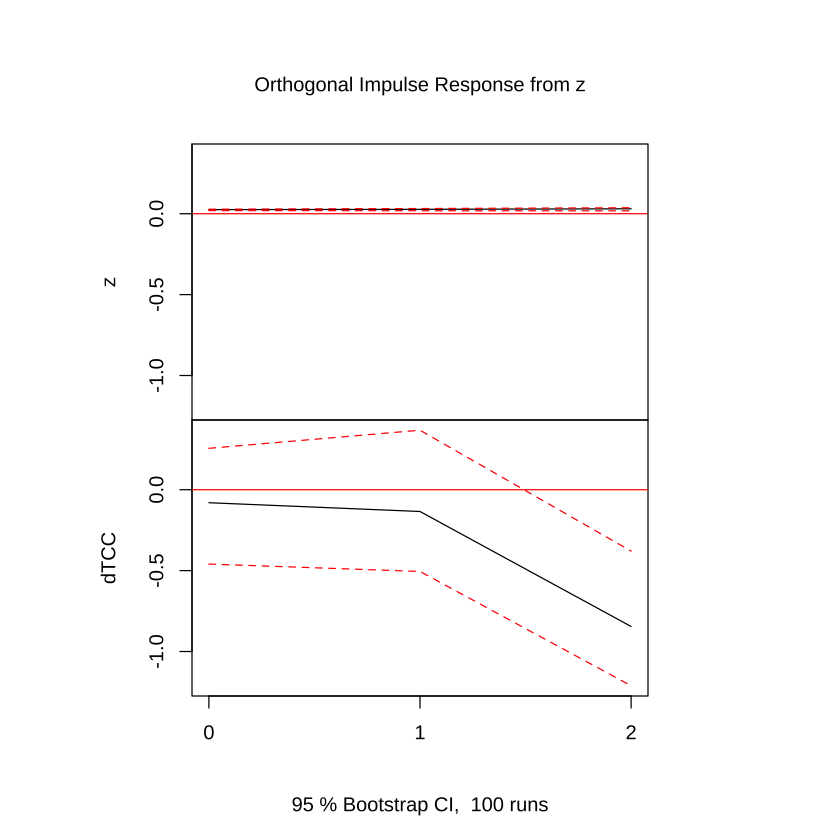

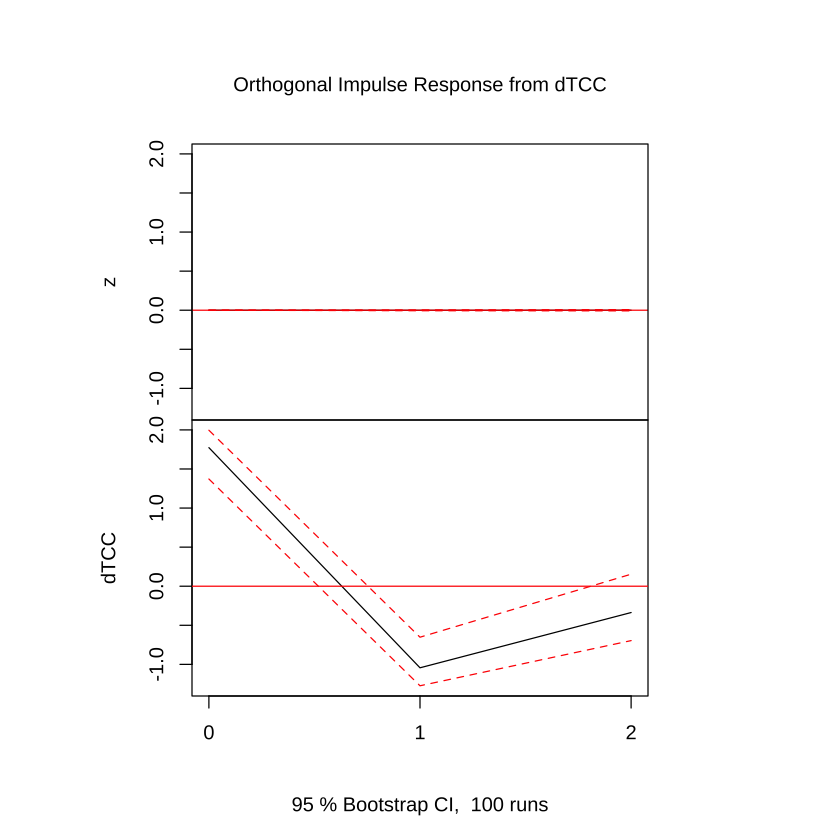

In [150]:
# On change l'ordre des variables dans le VAR en vertu de la section pecedente
endogen2 <- ts.intersect(z,dTCC)
var5_bis <-VAR(y=endogen2, lag.max=pniv,type='const')
fr1<-irf(var5_bis,ortho=TRUE,n.ahead=2,ci=0.95)
plot(fr1)

Les réponses impulsionnelles révèlent des interactions dynamiques asymétriques entre *z* et *dTCC*. Un choc orthogonal sur *z* provoque une réponse négative transitoire de *dTCC*, avec un effet maximal au premier horizon et un retour progressif à l'équilibre. Inversement, un choc sur dTCC engendre une réaction initialement négative de *z*, dont l'amplitude est plus modérée et s'estompe rapidement. Les intervalles de confiance à 95 % montrent que ces effets, bien que transitoires, sont significatifs dans les premiers horizons.

### b. Méthode des projections locales
.

[[1]]
NULL


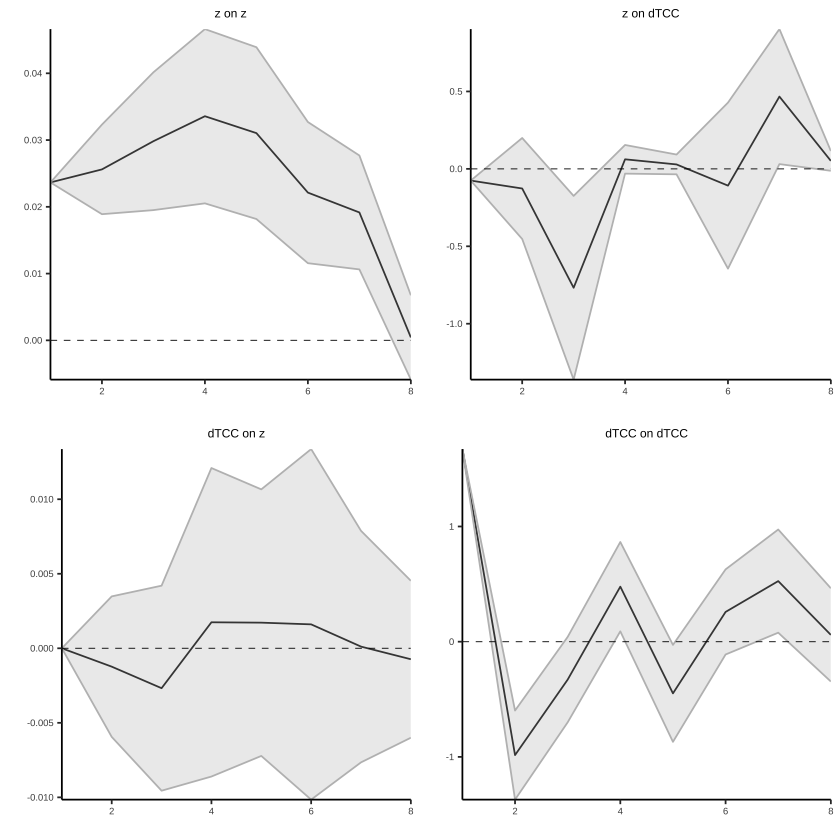

In [152]:
fr2<-lp_lin(endog_data=as.data.frame(endogen2),
            lags_endog_lin=NaN,
            lags_criterion = 'AIC',
            max_lags=4,
            trend=0,
            shock_type=0,
            confint=1.96,
            hor=8)
plot(fr2)

- **Réponse de *z* à un choc orthogonal sur _z_** : le graphique en haut à gauche montre une persistance positive des effets de *z* sur lui-même, avec une tendance décroissante au fil des horizons temporels. Les intervalles de confiance encadrent ces effets, confirmant leur significativité initiale.

- **Réponse de *dTCC* à un choc orthogonal sur _z_** : en haut à droite, la réponse initiale de *dTCC* à un choc sur *z* est négative avant de fluctuer autour de zéro. Ces oscillations reflètent une dynamique complexe, mais leur significativité est limitée aux premiers horizons.

- **Réponse de *z* à un choc orthogonal sur _dTCC_** : en bas à gauche, les effets sur *z* d’un choc sur *dTCC* sont très faibles et proches de zéro, indiquant une absence de relation significative entre les deux variables pour cette direction de causalité.

- **Réponse de *dTCC* à un choc orthogonal sur _dTCC_** : en bas à droite, *dTCC* répond à ses propres chocs de manière oscillatoire avec une forte réponse initiale, suivie d'une dissipation progressive. Les intervalles de confiance suggèrent une significativité notable sur les premiers horizons.

## 2.4 Test de cointégration

Pour terminer, nous allons tester si les séries initiales (non différenciées) présentent une relation de cointégration à l'aide du test de Johansen. Basé sur un VAR, ce test identifie le nombre de relations de cointégration via la statistiques de trace. La présence de cointégration justifie l’estimation d’un modèle vectoriel à correction d’erreur (VECM) pour intégrer les dynamiques de court et long terme. Cette section applique et interprète ce test afin de valider ou non le modèle VAR initial.

In [155]:
#choix du retard sur le VAR en niveau
pselec<-VARselect(y=ts.intersect(TCC,log_taux_de_chomage),lag.max=4,type='none')
print(pselec$selection)
#on choisit donc 3 retards

test <- ca.jo(x=ts.intersect(TCC,log_taux_de_chomage),type='trace',K=3,spec='transitory',ecdet='const')
summary(test)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      3      3      3 



###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 0.11963887 0.06194108 0.00000000

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.73  7.52  9.24 12.97
r = 0  | 14.16 17.85 19.96 24.60

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                           TCC.l1 log_taux_de_chomage.l1   constant
TCC.l1                   1.000000                1.00000    1.00000
log_taux_de_chomage.l1   7.957646               44.07665   41.25913
constant               -22.876038             -100.34951 -113.91948

Weights W:
(This is the loading matrix)

                            TCC.l1 log_taux_de_chomage.l1      constant
TCC.d                 -0.176883048           -0.118380436  2.673384e-17
log_taux_de_chomage.d  0.004334438           -0.001011658 -4.996978e-18


Le test de cointégration de Johansen permet de tester les hypothèses suivantes :

- $H_0 : r = 0$ (absence de relation de cointégration entre les variables)

- $H_1 : r > 0$ (présence d’au moins une relation de cointégration entre les variables)

La statistique de test pour $r = 0$ est de $14.16$, inférieure à la valeur critique au seuil de 5% ($19.96$). Nous ne rejetons donc pas $H_0$ ce qui indique l’absence de relation de cointégration. Il est alors inutile d'estimer un VECM.

On peut donc déduire que le VAR en niveau reste approprié pour modéliser les dynamiques entre les variables

# Conclusion

Cette étude économétrique a permis de mieux comprendre les relations dynamiques entre le taux de chômage et le taux de croissance des crédits accordés aux entreprises non financières. L’approche univariée a d’abord permis de stationnariser les séries pour modéliser leurs dynamiques individuelles à l’aide de processus ARMA. Les prévisions réalisées, bien que limitées par la proximité des racines du modèle avec le cercle unitaire, se sont révélées robustes à court terme.

Dans un second temps, l’analyse multivariée a mis en évidence des relations intéressantes entre les deux séries. Le modèle VAR a révélé une causalité significative du taux de chômage vers la croissance des crédits, mais pas l’inverse, ce qui a été confirmé par les tests de causalité de Granger. Par ailleurs, l’analyse impulsion-répulsion a montré des interactions dynamiques asymétriques, et le test de cointégration a mis en lumière une relation de long terme entre ces deux variables.